# Performing machine learning pipeline on EEG brainwave dataset from Kaggle 
https://www.kaggle.com/datasets/wanghaohan/confused-eeg/data?select=EEG_data.csv

## Ploting Libraries in Python
>**Numpy** to provide support for large, multi-dimensional arrays and matrices. Used for numerical computations, data transformations, and feature engineering.

>**Pandas** to provides a concise way to manipulate data in tabular format. Essential for data loading, preprocessing, exploration, and cleaning.

>**Seaborn** to perform Statistical data visualization library built on matplotlib. Used to plot distributions, correlation heatmaps, and relationships between variables.

>**Scipy** to perform feature selection, hypothesis testing, and data normalization/standardization.

>**Matplotlib** to perform exploratory data analysis, plotting learning curves, and evaluating model performance visually.

>**sklearn.model_selection import train_test_split, GridSearchCV** to perform unbiased evaluation pipelines and improving model performance.

>**sklearn.preprocessing import LabelEncoder, StandardScaler** to prepare categorical and numerical data for modeling.

>**sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix** to perform model predictions to assess model quality.

>**sklearn.linear_model import LogisticRegression** to interpret classification model in binary classification.

>**xgboost as xgb** to perform building highly accurate models with handling of missing data, regularization, and support for custom objectives.

>**imblearn.over_sampling import SMOTE** to handle class imbalance, which is common in many real-world classification problems.


In [501]:
# Importing required libraries

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [502]:
# Defining a dataframe as df

df = pd.read_csv('/home/pnandini/aai_jupyter/aai_510/EEG_data.csv')

In [503]:
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [504]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


## Initial Data Exploration and Summary Statistics

In [505]:
# Introducing artificial missing values

def introduce_missing(df, pct=0.01):
    df_missing = df.copy()
    np.random.seed(42)
    n_rows, n_cols = df_missing.shape
    num_missing = int(pct * n_rows * (n_cols - 1))  # exclude label column

    for _ in range(num_missing):
        i = np.random.randint(0, n_rows)
        j = np.random.randint(0, n_cols - 1)  # avoid 'label' column
        df_missing.iat[i, j] = np.nan
    return df_missing
df = introduce_missing(df, pct=0.01)

# Understanding Missing values

In [506]:

# Impute missing numerical data with mean
def impute_missing_numerical(df, exclude_cols=None):
    """
    Impute missing numerical values in a DataFrame with column-wise mean.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    exclude_cols (list, optional): Columns to exclude from imputation (e.g., label columns)

    Returns:
    pandas.DataFrame: A copy of the original DataFrame with imputed values
    """
    # Create a copy of the DataFrame
    df_imputed = df.copy()

    # Determine which columns to exclude
    if exclude_cols is None:
        exclude_cols = []

    # Select only numerical columns excluding the ones to skip
    numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    impute_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Impute each column with its mean
    for col in impute_cols:
        mean_val = df_imputed[col].mean()
        df_imputed[col] = df_imputed[col].fillna(mean_val)

    # Visualization of missing values before imputation
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title("Missing Values Before Imputation")
    plt.tight_layout()
    plt.show()

    # Visualization of missing values after imputation
    plt.figure(figsize=(10, 5))
    sns.heatmap(df_imputed.isnull(), yticklabels=False, cbar=False, cmap='coolwarm')
    plt.title("Missing Values After Imputation")
    plt.tight_layout()
    plt.show()

    return df_imputed


# Full Pipeline

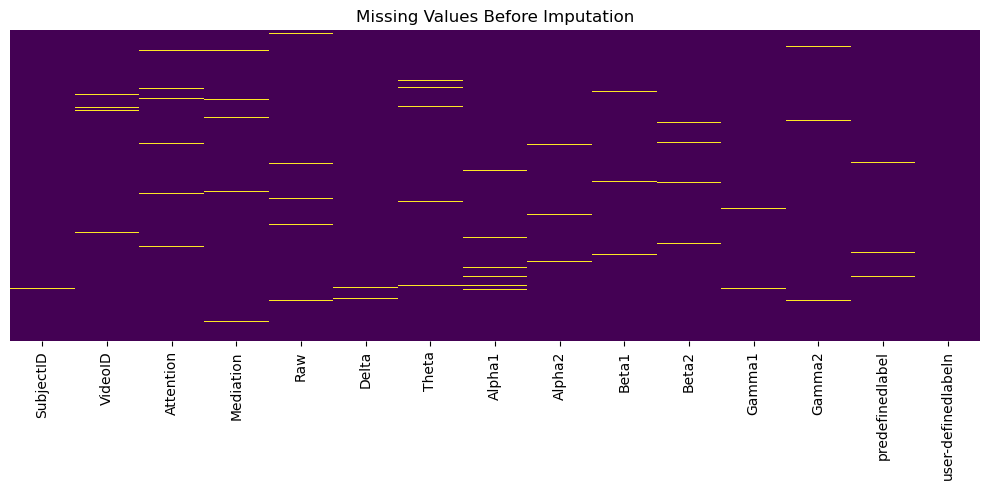

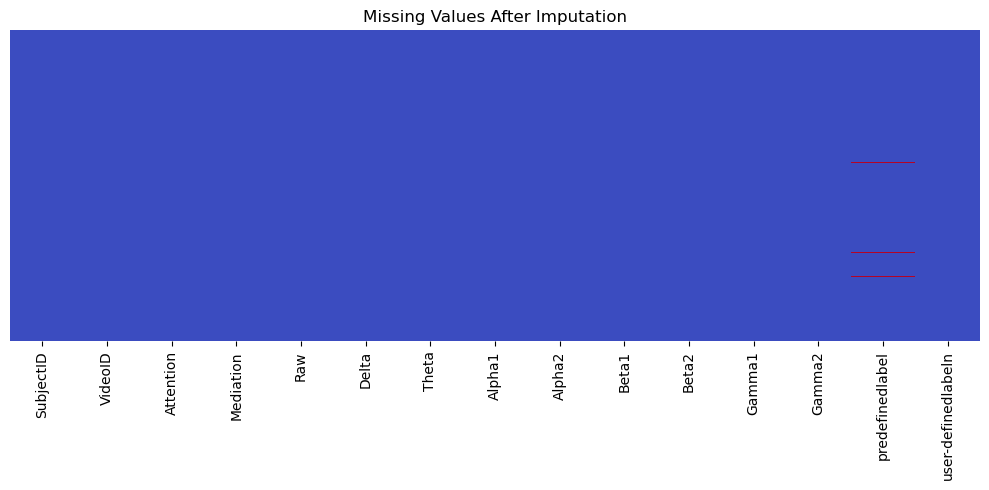

In [507]:
# Step 1: Imputing missing values

exclude_columns = ['predefinedlabel', 'user-definedlabeln']
df_imputed = impute_missing_numerical(df, exclude_cols=exclude_columns)

In [508]:
def encode_labels(df, label_col='predefinedlabel', new_col='label'):
    """
    Encode categorical labels using LabelEncoder and return label mapping.
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    label_col (str): Column name of the label to encode
    new_col (str): Name of the new encoded label column
    Returns:
    tuple: (DataFrame with encoded label column, mapping dictionary)
    """
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    df_encoded[new_col] = label_encoder.fit_transform(df_encoded[label_col])
    
    # Create mapping dictionary
    label_mapping = {original: encoded for encoded, original in enumerate(label_encoder.classes_)}
    return df_encoded, label_mapping


/tmp/ipykernel_1926/1240390573.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=class_counts.values, palette='Set2')


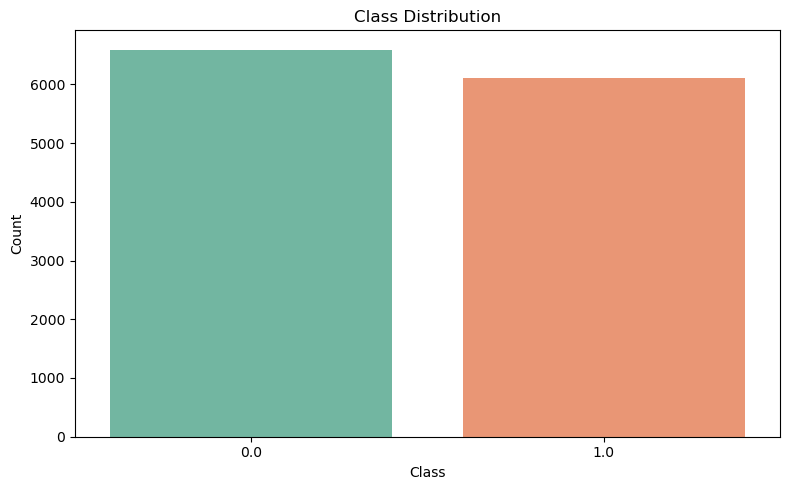

In [509]:
# Step 3: Plotting class distribution

def plot_class_distribution(df, label_col='label', mapping=None):
    class_counts = df[label_col].value_counts().sort_index()
    labels = [mapping[i] if mapping else i for i in class_counts.index]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=class_counts.values, palette='Set2')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Encode labels
df_encoded, label_mapping = encode_labels(df_imputed, label_col='predefinedlabel', new_col='label')

#Plotting class distribution
plot_class_distribution(df_encoded, mapping={v: k for k, v in label_mapping.items()})


In [ ]:
# Step 5: Feature analysis

def analyze_numeric_variable(df, column_name, bins=30):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    data_complete = df[df[column_name].notna()][column_name]
    data_missing = df[df[column_name].isna()]
    
    try:
        k2, p = stats.normaltest(data_complete) if len(data_complete) >= 20 else (np.nan, np.nan)
    except Exception as e:
        k2, p = np.nan, np.nan

    stats_dict = {
        'descriptive_stats': data_complete.describe(),
        'skewness': data_complete.skew(),
        'kurtosis': data_complete.kurtosis(),
        'normality_test_statistic': k2,
        'normality_test_pvalue': p,
        'missing_count': len(data_missing),
        'missing_percentage': round((len(data_missing) / len(df) * 100), 2)
    }

    # Visualization of plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    sns.histplot(data_complete, bins=bins, kde=True, ax=ax1, color='skyblue')
    ax1.set_title(f'Distribution of {column_name}')

    sns.boxplot(y=data_complete, ax=ax2, color='lightgreen')
    ax2.set_title(f'Box Plot of {column_name}')

    ax3.plot(df.index, df[column_name], 'o', alpha=0.4)
    ax3.set_title(f'Missing Pattern of {column_name}')

    plt.tight_layout()
    plt.show()

    return stats_dict


## Correlation overview

In [ ]:
def analyze_correlations(df, method='pearson'):
    """
    Analyze correlations between numerical variables, handling missing values.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    method (str): Correlation method ('pearson', 'spearman', or 'kendall')

    Returns:
    dict: Dictionary containing correlation analyses
    """
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Correlation of actual values
    correlation_matrix = df[numerical_cols].corr(method=method)

    # Correlation of missing value patterns
    missing_correlation = df[numerical_cols].isnull().corr()

    # Creating correlation heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Plotting value correlations
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax1)
    ax1.set_title('Value Correlations')

    # Missing pattern correlations
    sns.heatmap(missing_correlation, annot=True, cmap='coolwarm', center=0, ax=ax2)
    ax2.set_title('Missing Pattern Correlations')

    plt.tight_layout()

    return {
        'value_correlations': correlation_matrix,
        'missing_correlations': missing_correlation
    }

correlations = analyze_correlations(df)
print("\nValue Correlations:")
print(correlations['value_correlations'])


Value Correlations:
                    SubjectID   VideoID  Attention  Mediation       Raw  \
SubjectID            1.000000 -0.006258  -0.179809  -0.171673  0.026740   
VideoID             -0.006258  1.000000  -0.041805   0.006110  0.009679   
Attention           -0.179809 -0.041805   1.000000   0.550268 -0.095969   
Mediation           -0.171673  0.006110   0.550268   1.000000 -0.109052   
Raw                  0.026740  0.009679  -0.095969  -0.109052  1.000000   
Delta                0.204738  0.011373  -0.221512  -0.113372  0.049773   
Theta                0.122930  0.001593  -0.258926  -0.181703  0.051558   
Alpha1               0.118714  0.016190  -0.198257  -0.044188  0.044163   
Alpha2               0.154952 -0.008644  -0.246518  -0.154367  0.062944   
Beta1                0.100299  0.008179  -0.254968  -0.242152  0.088764   
Beta2                0.149881 -0.071949  -0.305287  -0.391462  0.174471   
Gamma1               0.101040 -0.054980  -0.300244  -0.346257  0.186251   
Gamm

Feature shape: (11147, 13)
Target shape: (11147,)


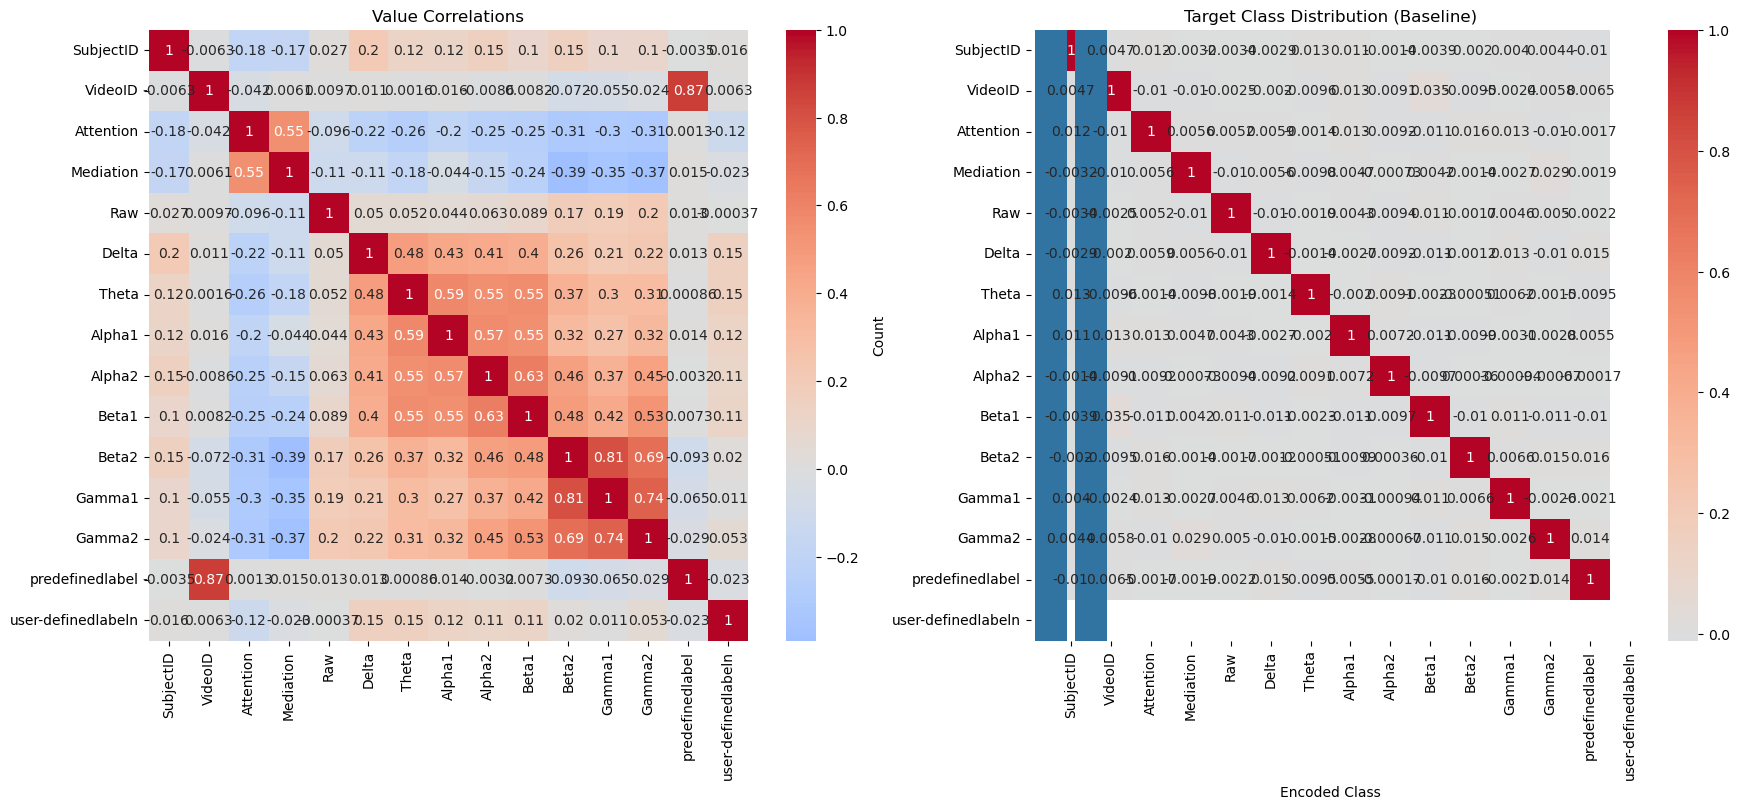

In [ ]:
# Droping missing values for baseline
df_baseline = df.dropna().copy()

label_encoder = LabelEncoder()
df_baseline['label'] = label_encoder.fit_transform(df_baseline['predefinedlabel'])

# Splitting features and target
X = df_baseline.drop(['label', 'predefinedlabel', 'user-definedlabeln'], axis=1, errors='ignore')
y = df_baseline['label']

# One-hot encode categorical variables
# creating binary column for each category
X = pd.get_dummies(X)

# Printing shape for verification
print("Feature shape:", X.shape)
print("Target shape:", y.shape)

# Plotting the distribution of target
sns.countplot(x=y)
plt.title("Target Class Distribution (Baseline)")
plt.xlabel("Encoded Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Performing Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [514]:
# Applying SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Performing train logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [ ]:
# Evaluate baseline model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1164
           1       1.00      1.00      1.00      1066

    accuracy                           1.00      2230
   macro avg       1.00      1.00      1.00      2230
weighted avg       1.00      1.00      1.00      2230



In [ ]:
# Step 11: XGBoost with grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
#Applying XGB classifier
xgb_clf = xgb.XGBClassifier(
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(label_mapping),
    random_state=42
)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Printing the best Parameters
print("\n=== Best Parameters ===")
print(grid_search.best_params_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/pnandini/miniconda3/envs/aai_500/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/pnandini/miniconda3/envs/aai_500/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manyli


=== Best Parameters ===
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


/home/pnandini/miniconda3/envs/aai_500/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pnandini/miniconda3/envs/aai_500/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pnandini/miniconda3/envs/aai_500/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pnandini/miniconda3/envs/aai_500/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, 

In [519]:
print("y_test shape:", y_test.shape)
print("y_test sample:", y_test[:5])
print("y_pred shape:", y_pred.shape)
print("y_pred sample:", y_pred[:5]) 

y_test shape: (2230,)
y_test sample: 4837     1
4661     1
12801    1
7603     1
9378     0
Name: label, dtype: int64
y_pred shape: (2230,)
y_pred sample: [1 1 1 1 0]


In [520]:
# Ensure y_test is a plain array
y_test_array = y_test.values  # or use y_test.to_numpy()

print("\n=== Classification Report ===")
print(classification_report(y_test_array, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test_array, y_pred))



=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1164
           1       1.00      1.00      1.00      1066

    accuracy                           1.00      2230
   macro avg       1.00      1.00      1.00      2230
weighted avg       1.00      1.00      1.00      2230


=== Confusion Matrix ===
[[1164    0]
 [   0 1066]]


In [ ]:
# Feature engineering
def add_band_power_ratios(df):
    df = df.copy()
    # Theta / Alpha Ratio
    df['theta_alpha_ratio'] = df['Theta'] / (df['Alpha1'] + df['Alpha2'] + 1e-9)
    # Beta / Alpha Ratio
    df['beta_alpha_ratio'] = (df['Beta1'] + df['Beta2']) / (df['Alpha1'] + df['Alpha2'] + 1e-9)
    # Engagement Index
    df['engagement_index'] = (df['Beta1'] + df['Beta2']) / (df['Alpha1'] + df['Theta'] + 1e-9)
    return df

def log_transform_skewed(df, cols=None):
    df = df.copy()
    if cols is None:
        cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    for col in cols:
        if (df[col] > 0).all():
            df[f'log_{col}'] = np.log1p(df[col])
    return df

def run_anova_test(df, numerical_cols, label_col):
    results = []
    for col in numerical_cols:
        groups = [group[col].dropna() for _, group in df.groupby(label_col)]
        try:
            f_val, p_val = stats.f_oneway(*groups)
            results.append({'feature': col, 'f_value': f_val, 'p_value': p_val})
        except:
            continue
    return pd.DataFrame(results).sort_values('p_value')

# Feature Engineering and Missing Value Imputation on the EEG data

In [ ]:
# Imputing missing values in numerical column
def impute_missing_values(df, strategy='mean'):
    """
    Impute missing values in numerical columns.

    Parameters:
    df (pd.DataFrame): Input dataframe
    strategy (str): Imputation strategy ('mean', 'median')

    Returns:
    pd.DataFrame: Imputed dataframe
    """
    df_imputed = df.copy()
    numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns

    for col in numeric_cols:
        if strategy == 'mean':
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())
        elif strategy == 'median':
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
        else:
            raise ValueError("Unsupported strategy. Use 'mean' or 'median'.")

    return df_imputed


In [ ]:
#
def add_band_power_ratios(df):
    df = df.copy()

    # Theta / Alpha Ratio
    # Often used to study cognitive workload or drowsiness.
    df['theta_alpha_ratio'] = df['Theta'] / (df['Alpha1'] + df['Alpha2'] + 1e-9)
    # Beta / Alpha Ratio
    # May reflect attention level or mental concentration.
    df['beta_alpha_ratio'] = (df['Beta1'] + df['Beta2']) / (df['Alpha1'] + df['Alpha2'] + 1e-9)
    # Engagement Index
    # Higher engagement is associated with higher beta activity and lower alpha & theta.
    df['engagement_index'] = (df['Beta1'] + df['Beta2']) / (df['Alpha1'] + df['Theta'] + 1e-9)
    
    return df


In [ ]:
#Applying log for model performance
def log_transform_skewed(df, cols=None):
    df = df.copy()
    if cols is None:
        cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    for col in cols:
        if (df[col] > 0).all():  # avoid log(0)
            df[f'log_{col}'] = np.log1p(df[col])
    return df


In [ ]:
# 1. Imputing dataset
df_cleaned = impute_missing_values(df, strategy='mean')

# Adding engineered features
df_engineered = add_band_power_ratios(df_cleaned)
df_engineered = log_transform_skewed(df_engineered)

# Encoding label
label_encoder = LabelEncoder()
df_engineered['label'] = label_encoder.fit_transform(df_engineered['predefinedlabel'])

# Splitting X and y
X = df_engineered.drop(['label', 'predefinedlabel', 'user-definedlabeln'], axis=1, errors='ignore')
y = df_engineered['label']


In [526]:
def run_anova_test(df, numerical_cols, label_col):
    results = []
    for col in numerical_cols:
        groups = [group[col].dropna() for _, group in df.groupby(label_col)]
        try:
            f_val, p_val = stats.f_oneway(*groups)
            results.append({'feature': col, 'f_value': f_val, 'p_value': p_val})
        except:
            continue
    result_df = pd.DataFrame(results)
    return result_df.sort_values('p_value')


# Full Pipeline

/home/pnandini/miniconda3/envs/aai_500/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:35:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1747336936436/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9840

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1318
           1       0.00      0.00      0.00        25
           2       0.98      0.99      0.99      1220

    accuracy                           0.98      2563
   macro avg       0.66      0.66      0.66      2563
weighted avg       0.98      0.98      0.98      2563



/tmp/ipykernel_1926/2464262596.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


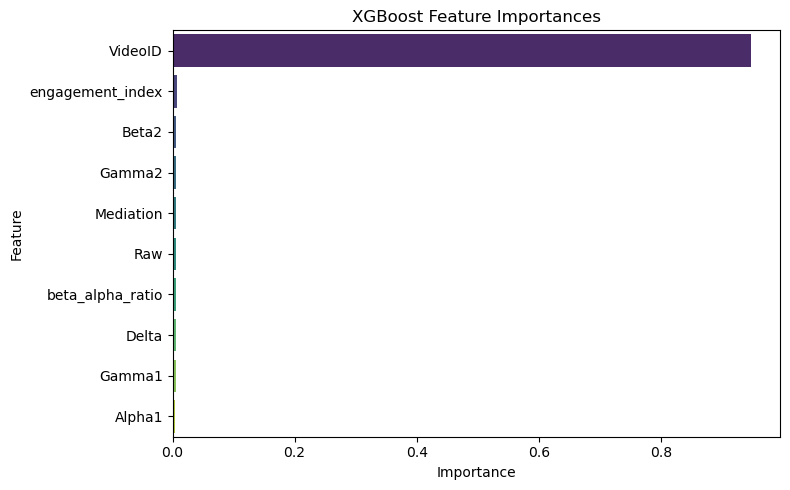

In [ ]:
def full_pipeline(df):
    # Imputing datatset
    df_clean = impute_missing_values(df, strategy='mean')

    # Performing feature engineering
    df_fe = add_band_power_ratios(df_clean)

    # Performing encode label
    label_encoder = LabelEncoder()
    df_fe['label'] = label_encoder.fit_transform(df_fe['predefinedlabel'])

    # Performing feature selection using ANOVA
    num_cols = [
        col for col in df_fe.columns
        if df_fe[col].dtype in ['float64', 'int64']
        and col not in ['label', 'predefinedlabel', 'user-definedlabeln']
    ]
    anova_results = run_anova_test(df_fe, num_cols, 'label')
    top_features = anova_results.head(10)['feature'].tolist()

    # Preparing features and labels
    X = df_fe[top_features]
    y = df_fe['label']

    # Performing train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #  Performing XGBoost
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Performing evaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

    # Performing feature Importance Plot
    importance = model.feature_importances_
    feat_imp_df = pd.DataFrame({'Feature': top_features, 'Importance': importance})
    feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)
    
    #Plotting barplot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
    plt.title("XGBoost Feature Importances")
    plt.tight_layout()
    plt.show()

    return model, feat_imp_df, anova_results
model, feat_imp_df, anova_results = full_pipeline(df)